In [3]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
from astropy.io.votable import parse
from astropy.coordinates import SkyCoord
from astropy import units as u 
from sunpy.coordinates import frames
from sunpy.time import parse_time
import datetime
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings("ignore")

This data is being pulled from HELIO https://www.helio-vo.eu/ from the `gevloc_sxr_flare` table

In [6]:
def get_helio_flarelist():
    aa = parse("http://hec.helio-vo.eu/hec/hec_gui_fetch.php?interfacetype=vmstilts&sql=select+%2A+from+gevloc_sxr_flare+where+time_start%3E%3D%272010-01-01+00%3A00%3A00%27+AND+time_start%3C%3D%272018-12-31+23%3A59%3A59%27&type=votable")
    full_table = aa.get_first_table().to_table().to_pandas()
    # full_table.head()
    full_table["goes_class_ind"] = [x[0] for x in full_table["xray_class"]]
    full_table["goes_class_val"] = full_table["xray_class"].map(get_goes_class)
    full_table.to_csv("helio_flarelist_full.csv", index_label=False)
get_helio_flarelist()

In [7]:
def get_goes_class(x):
    if x[0]=="C":
        return float(x[1:])*1e-6
    elif x[0] == "M":
        return float(x[1:])*(1e-5)
    elif x[0] == "X":
        return float(x[1:])*(1e-4)
    elif x[0] == "B":
        return float(x[1:])*(1e-7)
    elif x[0] == "A":
        return float(x[1:])*(1e-8)
    else:
        return

In [8]:
full_table = pd.read_csv("helio_flarelist_full.csv")
full_table.head(3)

,time_start,time_end,time_peak,xray_class,lat_hg,long_hg,long_carr,nar,ename,url_nar,url_flare,goes_class_ind,goes_class_val
0,2010-01-01 12:02:00.0,2010-01-01 12:18:00.0,2010-01-01 12:09:00.0,B1.9,-29,31,57.28,11039.0,gev_20100101_1202,http://www.solarmonitor.org/region.php?date=20...,http://www.lmsal.com/solarsoft/latest_events_a...,B,1.900000e-07
1,2010-01-01 12:33:00.0,2010-01-01 13:00:00.0,2010-01-01 12:43:00.0,B2.3,-24,34,60.00,11039.0,gev_20100101_1233,http://www.solarmonitor.org/region.php?date=20...,http://www.lmsal.com/solarsoft/latest_events_a...,B,2.300000e-07
2,2010-01-01 23:29:00.0,2010-01-01 23:42:00.0,2010-01-01 23:33:00.0,B1.1,-25,39,59.00,11039.0,gev_20100101_2329,http://www.solarmonitor.org/region.php?date=20...,http://www.lmsal.com/solarsoft/latest_events_a...,B,1.100000e-07


In [48]:
helio_c = full_table[full_table["goes_class_ind"].isin(["X", "M", "C"])]
helio_c.reset_index(drop=True, inplace=True)
helio_c.to_csv("helio_flarelist_c.csv", index_label=True)

In [9]:
full_table["goes_class_ind"].unique()

array(['B', 'C', 'M', 'A', 'X'], dtype=object)

## Lets inspect data
Lets just focus on X, M, and C class flares

In [10]:
full_table_c = full_table[full_table["goes_class_ind"].isin(["X", "M", "C"])]

In [11]:
full_table_c.reset_index(inplace=True, drop=True)

In [12]:
full_table_c = full_table_c.fillna(-9999)

In [13]:
full_table_c.drop(full_table_c[(full_table_c["long_hg"] == 0) & (full_table_c["lat_hg"] == 0)].index, inplace=True)
full_table_c.drop(full_table_c[full_table_c.lat_hg<-60].index, inplace=True)
# full_table_c.drop(full_table_c[(full_table_c.nar==1000) | 
#                                (full_table_c.nar==-9999) | 
#                                (full_table_c.nar==0)].index, inplace=True)

In [14]:
print("X: {:d}, M: {:d}, C: {:d}".format(np.sum(full_table_c["goes_class_ind"].isin(["X"])), 
                                         np.sum(full_table_c["goes_class_ind"].isin(["M"])),
                                         np.sum(full_table_c["goes_class_ind"].isin(["C"]))))

X: 49, M: 726, C: 7941


In [15]:
coords_hgs = SkyCoord(full_table_c["long_hg"]*u.deg, full_table_c["lat_hg"]*u.deg,
                  frame=frames.HeliographicStonyhurst, observer="earth", obstime=pd.to_datetime(full_table_c["time_start"]))

In [16]:
coords_hpc = coords_hgs.transform_to(frames.Helioprojective(observer="earth"))

In [17]:
full_table_c["hpc_x"], full_table_c["hpc_y"] = coords_hpc.Tx.value, coords_hpc.Ty.value

In [18]:
full_table_c["time_start_datetime"] = pd.to_datetime(full_table_c["time_start"])
full_table_c["time_peak_datetime"] = pd.to_datetime(full_table_c["time_peak"])

In [19]:
full_table_c["tt"] = np.array([d.total_seconds() for d in full_table_c["time_start_datetime"] - full_table_c["time_start_datetime"].iloc[0]])/60/60

In [20]:
full_table_c["unique_day"] = full_table_c.time_start_datetime.dt.strftime("%Y-%m-%d")

In [21]:
full_table_c["unique_month"] = pd.to_datetime(full_table_c.time_start_datetime.dt.strftime("%Y-%m"))

In [22]:
len(full_table_c["unique_day"].unique())

1677

In [23]:
len(full_table_c["unique_month"].unique())

96

In [24]:
full_table_c["unique_day2"] = pd.to_datetime(full_table_c["unique_day"]) 

Text(0, 0.5, 'No flares')

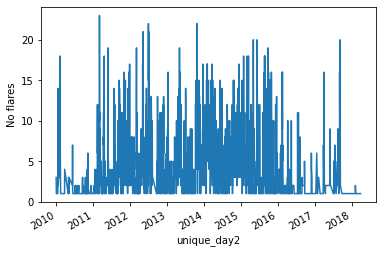

In [25]:
full_table_c.groupby("unique_day2")["goes_class_ind"].count().plot()
plt.ylabel("No flares")

Text(0, 0.5, 'No flares')

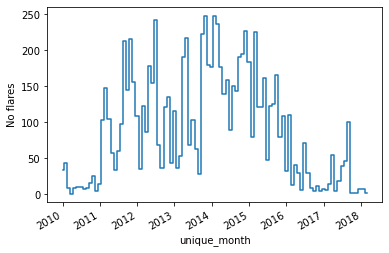

In [26]:
full_table_c.groupby("unique_month")["goes_class_ind"].count().plot(drawstyle="steps-mid")
plt.ylabel("No flares")

In [27]:
full_table_c_test = full_table_c[(full_table_c["nar"]!=-9999)&(full_table_c["nar"]!=0)&(full_table_c["nar"]!=10000)]

In [28]:
full_table_c_test["nar"] = full_table_c_test["nar"].astype("str")

In [29]:
%matplotlib inline
full_table_c_test.groupby("nar")["goes_class_ind"].count()

nar
11039.0     5
11040.0     2
11041.0    22
11045.0    23
11046.0     4
           ..
12680.0     2
12683.0     3
12685.0     1
12699.0     7
12700.0     1
Name: goes_class_ind, Length: 864, dtype: int64

## get unique days

In [30]:
# Pull out start and end times
tstart = parse_time("2010-01-01").datetime
tfinal = parse_time("2018-03-31").datetime
# create list and loop over to make unique list of days
time_over = [tstart.strftime('%Y-%m-%d')]
t0 = tstart
while t0 < tfinal:
    t0 = t0 + relativedelta(months=1)
    time_over.append(t0.strftime('%Y-%m-%d'))

In [31]:
time_over[0:2]

['2010-01-01', '2010-02-01']

In [32]:
import matplotlib.animation as animation

def animate(i):
    data = full_table_c[full_table_c["unique_month"].isin([time_over[i]])]
    
#     fig, ax = plt.subplots()

    circle1 = plt.Circle((0, 0), 960, color='k', fill=False)  
    ax.add_artist(circle1)
    ax.set_xlim(-1100, 1100)
    ax.set_ylim(-1100, 1100)
    ax.set_aspect('equal')
    if len(data)>0:
        ax.scatter(data["hpc_x"], data["hpc_y"], alpha=0.4, 
                   s=5*data["goes_class_val"]*1e6, c=data["tt"], cmap="magma")
    

<IPython.core.display.Javascript object>


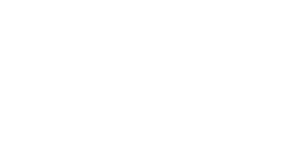

In [33]:
%matplotlib notebook
fig = plt.figure()
#creating a subplot 
ax = fig.add_subplot(1,1,1)
ani = animation.FuncAnimation(fig, animate, interval=500) 

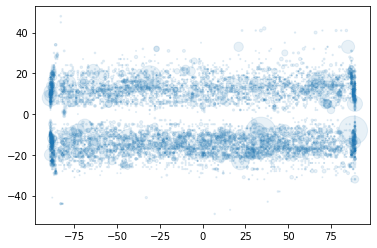

In [34]:
%matplotlib inline
plt.scatter(full_table_c["long_hg"], full_table_c["lat_hg"], 
            alpha=0.1, s=full_table_c["goes_class_val"]*1e6)

In [35]:
testy = full_table_c

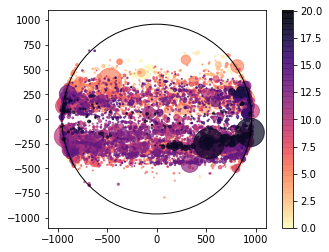

In [36]:
plt.scatter(testy["hpc_x"], testy["hpc_y"], alpha=0.7, s=testy["goes_class_val"]*1e6,
            cmap="magma_r", 
            c=full_table_c["tt"]/60/60, 
            #c=testy["goes_class_val"]*1e6, 
           )
plt.axes().set_aspect('equal')
circle1 = plt.Circle((0, 0), 960, color='k', fill=False)
plt.gca().add_artist(circle1)
plt.xlim(-1100, 1100)
plt.ylim(-1100, 1100)
plt.colorbar()

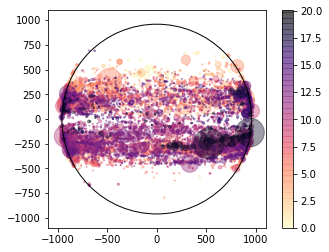

In [37]:
plt.scatter(testy["hpc_x"], testy["hpc_y"], alpha=0.4, s=testy["goes_class_val"]*1e6,
            c=full_table_c["tt"]/60/60, cmap="magma_r")
plt.axes().set_aspect('equal')
circle1 = plt.Circle((0, 0), 960, color='k', fill=False)
plt.gca().add_artist(circle1)
plt.xlim(-1100, 1100)
plt.ylim(-1100, 1100)
plt.colorbar()

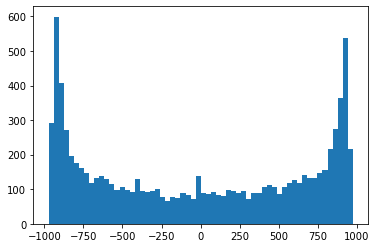

In [38]:
_ = plt.hist(coords_hpc.Tx.value, bins=60)

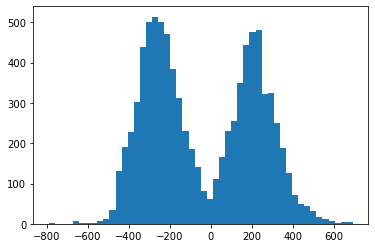

In [39]:
_ = plt.hist(coords_hpc.Ty.value, bins=50)

In [40]:
len(full_table_c)

8716

In [41]:
ar_data = pd.read_csv('/Users/laurahayes/spaceweather_stuff/SolarStatsStuff/ar_analysis/all_ar_2010-2020.csv')

In [42]:
len(ar_data["ar_noaanum"].unique())

1725

In [43]:
len(full_table_c["nar"].unique())

867

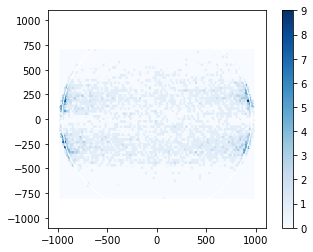

In [44]:
plt.hexbin(full_table_c["hpc_x"], full_table_c["hpc_y"], bins=10, cmap="Blues")
ax = plt.gca()
ax.set_aspect("equal")
circle1 = plt.Circle((0, 0), 960, color='w', fill=False)
plt.gca().add_artist(circle1)
plt.xlim(-1100, 1100)
plt.ylim(-1100, 1100)
plt.colorbar()

In [45]:
from matplotlib.colors import LogNorm
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable

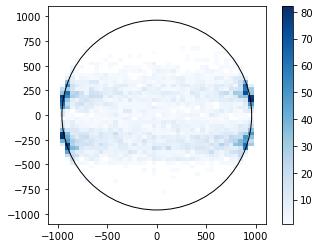

In [60]:
cmap = "viridis"
cmap = matplotlib.cm.get_cmap('Blues')
cmap.set_under("white", 1.0)
cc = rgba = cmap(0)
plt.hist2d(full_table_c["hpc_x"], full_table_c["hpc_y"], bins=40, cmap=cmap, vmin=1)
ax = plt.gca()
ax.set_aspect("equal")
# ax.set_facecolor(cc)
circle1 = plt.Circle((0, 0), 960, color='k', fill=False)
plt.gca().add_artist(circle1)
plt.xlim(-1100, 1100)
plt.ylim(-1100, 1100)
plt.colorbar()

In [61]:
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

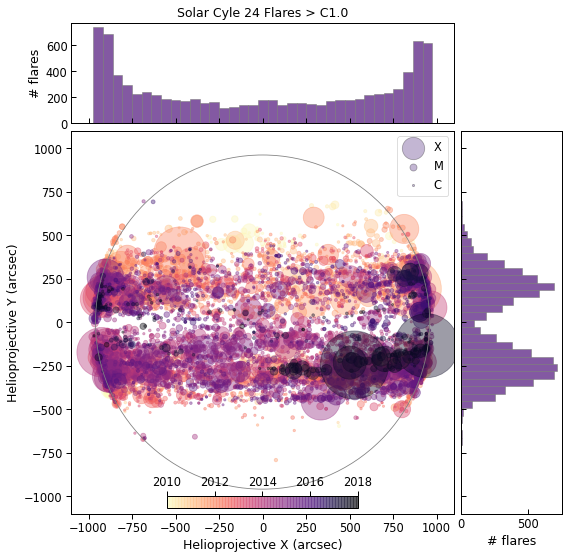

In [62]:
fig, ax = plt.subplots(figsize=(8, 8))

cmap = matplotlib.cm.get_cmap('magma_r')
cc = cmap(0.75)


axins1 = inset_axes(ax, 
                    width="50%",  # width = 50% of parent_bbox width
                    height="3%",  # height : 5%
                    loc='lower center')

# the scatter plot:
im = ax.scatter(testy["hpc_x"], testy["hpc_y"], alpha=0.4, s=5*testy["goes_class_val"]*1e6,
            c=full_table_c["tt"]/60/60, cmap=cmap)
circle1 = plt.Circle((0, 0), 960, color='grey', fill=False)
ax.add_artist(circle1)
# Set aspect of the main axes.
ax.set_aspect("equal")
ax.set_xlim(-1100, 1100)
ax.set_ylim(-1100, 1100)


# create new axes on the right and on the top of the current axes
divider = make_axes_locatable(ax)
# below height and pad are in inches
ax_histx = divider.append_axes("top", 1.4, pad=0.1, sharex=ax)
ax_histy = divider.append_axes("right", 1.4, pad=0.1, sharey=ax)

ax_histx.tick_params(labelbottom=False, direction="in")
ax_histy.tick_params(labelleft=False, direction="in")
# ax.tick_params(direction="in", right="in", top="in")

_ = ax_histx.hist(testy["hpc_x"], bins=35, color=cc, alpha=0.7,  edgecolor="grey")
_ = ax_histy.hist(testy["hpc_y"], bins=35, orientation='horizontal', color=cc, alpha=0.7, edgecolor="grey")

ax.set_xlabel("Helioprojective X (arcsec)")
ax.set_ylabel("Helioprojective Y (arcsec)")
ax_histx.set_ylabel("# flares")
ax_histy.set_xlabel("# flares")

ax_histx.set_title("Solar Cyle 24 Flares > C1.0")

cbar = fig.colorbar(im, cax=axins1, orientation="horizontal", ticks=[0, 5, 10, 15, 20])
axins1.set_xticklabels(['2010', '2012', '2014', '2016', '2018'], rotation=0) 
axins1.xaxis.tick_top()


ax.scatter(np.nan, np.nan, s=5*1e6*(1e-4), color=cmap(0.8), alpha=0.3, edgecolor="k", label="X")
ax.scatter(np.nan, np.nan, s=5*1e6*(1e-5), color=cmap(0.8), alpha=0.3, edgecolor="k", label="M")
ax.scatter(np.nan, np.nan, s=5*1e6*(1e-6), color=cmap(0.8), alpha=0.3, edgecolor="k", label="C")
ax.legend()
plt.tight_layout()

plt.savefig("testy.png", facecolor="w", dpi=200)

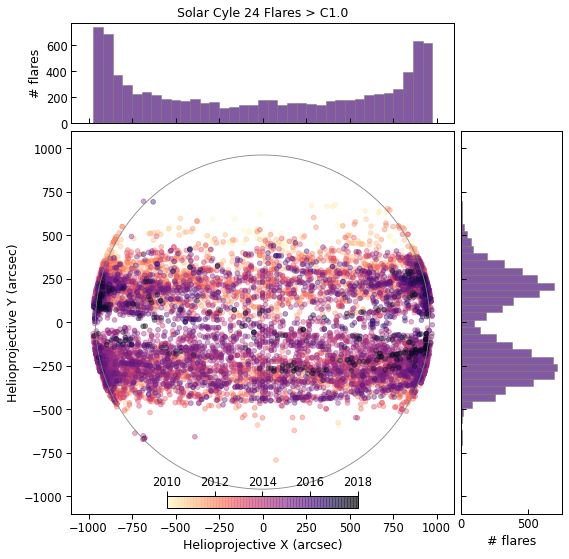

In [63]:
fig, ax = plt.subplots(figsize=(8, 8))

cmap = matplotlib.cm.get_cmap('magma_r')
cc = cmap(0.75)


axins1 = inset_axes(ax, 
                    width="50%",  # width = 50% of parent_bbox width
                    height="3%",  # height : 5%
                    loc='lower center')

# the scatter plot:
im = ax.scatter(testy["hpc_x"], testy["hpc_y"], alpha=0.4, 
            c=full_table_c["tt"]/60/60, cmap=cmap)
circle1 = plt.Circle((0, 0), 960, color='grey', fill=False)
ax.add_artist(circle1)
# Set aspect of the main axes.
ax.set_aspect("equal")
ax.set_xlim(-1100, 1100)
ax.set_ylim(-1100, 1100)


# create new axes on the right and on the top of the current axes
divider = make_axes_locatable(ax)
# below height and pad are in inches
ax_histx = divider.append_axes("top", 1.4, pad=0.1, sharex=ax)
ax_histy = divider.append_axes("right", 1.4, pad=0.1, sharey=ax)

ax_histx.tick_params(labelbottom=False, direction="in")
ax_histy.tick_params(labelleft=False, direction="in")
# ax.tick_params(direction="in", right="in", top="in")

_ = ax_histx.hist(testy["hpc_x"], bins=35, color=cc, alpha=0.7,  edgecolor="grey")
_ = ax_histy.hist(testy["hpc_y"], bins=35, orientation='horizontal', color=cc, alpha=0.7, edgecolor="grey")

ax.set_xlabel("Helioprojective X (arcsec)")
ax.set_ylabel("Helioprojective Y (arcsec)")
ax_histx.set_ylabel("# flares")
ax_histy.set_xlabel("# flares")

ax_histx.set_title("Solar Cyle 24 Flares > C1.0")

cbar = fig.colorbar(im, cax=axins1, orientation="horizontal", ticks=[0, 5, 10, 15, 20])
axins1.set_xticklabels(['2010', '2012', '2014', '2016', '2018'], rotation=0) 
axins1.xaxis.tick_top()

plt.tight_layout()

plt.savefig("testy2.png", facecolor="w", dpi=200)

In [64]:

def make_movie(i)
    
    data = full_table_c[full_table_c["unique_month"].isin([time_over[i]])]
    
    cmap = matplotlib.cm.get_cmap('magma_r')
    cc = cmap(0.75)


    axins1 = inset_axes(ax, 
                        width="50%",  # width = 50% of parent_bbox width
                        height="3%",  # height : 5%
                        loc='lower center')

    # the scatter plot:
    im = ax.scatter(data["hpc_x"], data["hpc_y"], alpha=0.4, s=5*data["goes_class_val"]*1e6,
                c=data["tt"]/60/60, cmap=cmap)
    circle1 = plt.Circle((0, 0), 960, color='grey', fill=False)
    ax.add_artist(circle1)
    # Set aspect of the main axes.
    ax.set_aspect("equal")
    ax.set_xlim(-1100, 1100)
    ax.set_ylim(-1100, 1100)


    # create new axes on the right and on the top of the current axes
    divider = make_axes_locatable(ax)
    # below height and pad are in inches
    ax_histx = divider.append_axes("top", 1.4, pad=0.1, sharex=ax)
    ax_histy = divider.append_axes("right", 1.4, pad=0.1, sharey=ax)

    ax_histx.tick_params(labelbottom=False, direction="in")
    ax_histy.tick_params(labelleft=False, direction="in")
    # ax.tick_params(direction="in", right="in", top="in")

    _ = ax_histx.hist(data["hpc_x"], bins=35, color=cc, alpha=0.7,  edgecolor="grey")
    _ = ax_histy.hist(data["hpc_y"], bins=35, orientation='horizontal', color=cc, alpha=0.7, edgecolor="grey")

    ax.set_xlabel("Helioprojective X (arcsec)")
    ax.set_ylabel("Helioprojective Y (arcsec)")
    ax_histx.set_ylabel("# flares")
    ax_histy.set_xlabel("# flares")

    ax_histx.set_title("Solar Cyle 24 Flares > C1.0")

    cbar = fig.colorbar(im, cax=axins1, orientation="horizontal", ticks=[0, 5, 10, 15, 20])
    axins1.set_xticklabels(['2010', '2012', '2014', '2016', '2018'], rotation=0) 
    axins1.xaxis.tick_top()


    ax.scatter(np.nan, np.nan, s=5*1e6*(1e-4), color=cmap(0.8), alpha=0.3, edgecolor="k", label="X")
    ax.scatter(np.nan, np.nan, s=5*1e6*(1e-5), color=cmap(0.8), alpha=0.3, edgecolor="k", label="M")
    ax.scatter(np.nan, np.nan, s=5*1e6*(1e-6), color=cmap(0.8), alpha=0.3, edgecolor="k", label="C")
    ax.legend()
    plt.tight_layout()



SyntaxError: invalid syntax (<ipython-input-64-41e62059a528>, line 1)

In [ ]:
%matplotlib notebook
fig = plt.figure(figsize=(8, 8))
#creating a subplot 
ax = fig.add_subplot(1,1,1)
ani = animation.FuncAnimation(fig, animate, interval=500) 

## Testing Leka et al. 2019

In [66]:
final_list = full_table[full_table["goes_class_ind"].isin(["X", "M", "C"])]
final_list.reset_index(inplace=True)

In [67]:
final_list["tstart_datetime"] = pd.to_datetime(final_list["time_start"])
final_list.head()

,index,time_start,time_end,time_peak,xray_class,lat_hg,long_hg,long_carr,nar,ename,url_nar,url_flare,goes_class_ind,goes_class_val,tstart_datetime
0,4,2010-01-02 07:09:00.0,2010-01-02 07:40:00.0,2010-01-02 07:24:00.0,C1.0,-26,41,56.79,11039.0,gev_20100102_0709,http://www.solarmonitor.org/region.php?date=20...,http://www.lmsal.com/solarsoft/latest_events_a...,C,0.000001,2010-01-02 07:09:00
1,8,2010-01-02 14:08:00.0,2010-01-02 14:24:00.0,2010-01-02 14:16:00.0,C2.6,-28,40,51.96,11039.0,gev_20100102_1408,http://www.solarmonitor.org/region.php?date=20...,http://www.lmsal.com/solarsoft/latest_events_a...,C,0.000003,2010-01-02 14:08:00
2,10,2010-01-02 22:57:00.0,2010-01-02 23:35:00.0,2010-01-02 23:19:00.0,C3.1,-27,45,52.12,11039.0,gev_20100102_2257,http://www.solarmonitor.org/region.php?date=20...,http://www.lmsal.com/solarsoft/latest_events_a...,C,0.000003,2010-01-02 22:57:00
3,11,2010-01-03 01:17:00.0,2010-01-03 01:31:00.0,2010-01-03 01:22:00.0,C2.0,-28,49,54.84,11039.0,gev_20100103_0117,http://www.solarmonitor.org/region.php?date=20...,http://www.lmsal.com/solarsoft/latest_events_a...,C,0.000002,2010-01-03 01:17:00
4,21,2010-01-04 03:36:00.0,2010-01-04 03:42:00.0,2010-01-04 03:40:00.0,C1.3,-28,63,54.40,11039.0,gev_20100104_0336,http://www.solarmonitor.org/region.php?date=20...,http://www.lmsal.com/solarsoft/latest_events_a...,C,0.000001,2010-01-04 03:36:00


In [68]:
test_list = final_list[(final_list["tstart_datetime"]>="2016-01-01") & (final_list["tstart_datetime"]<="2017-01-01")]

In [69]:
test_list["unique_day"] = pd.to_datetime(test_list.tstart_datetime.dt.strftime("%Y-%m-%d"))

In [70]:
test_list_c = test_list
test_list_m = test_list[test_list["goes_class_ind"].isin(["X", "M"])]
test_list_x = test_list[test_list["goes_class_ind"].isin(["X"])]

In [71]:
print("C+:", len(test_list_c.groupby(["unique_day"])["goes_class_ind"].count()))
print("M+:", len(test_list_m.groupby(["unique_day"])["goes_class_ind"].count()))
print("X+:", len(test_list_x.groupby(["unique_day"])["goes_class_ind"].count()))

C+: 116
M+: 11
X+: 0


That is great - its the same event days as presented in table 2 of Leka et al. 2019.

In [72]:
test_list_x

,index,time_start,time_end,time_peak,xray_class,lat_hg,long_hg,long_carr,nar,ename,url_nar,url_flare,goes_class_ind,goes_class_val,tstart_datetime,unique_day


In [73]:
np.sum(final_list["goes_class_ind"].isin(["X"]))

49

In [78]:
final_list_x = final_list[final_list["goes_class_ind"]=="X"]

In [79]:
coords_hgs = SkyCoord(final_list_x["long_hg"]*u.deg, final_list_x["lat_hg"]*u.deg,
                  frame=frames.HeliographicStonyhurst, observer="earth", obstime=pd.to_datetime(final_list_x["time_start"]))

In [80]:
coords_hpc = coords_hgs.transform_to(frames.Helioprojective)

In [85]:
coords_hpc[20]

<SkyCoord (Helioprojective: obstime=2013-10-25T14:51:00.000000000, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2013-10-25T14:51:00.000000000): (lon, lat, radius) in (deg, deg, AU)
    (0., 4.99336141, 0.99425378)>): (Tx, Ty, distance) in (arcsec, arcsec, km)
    (-897.20388297, -130.60217643, 1.48499002e+08)>

In [90]:
coords_hc = coords_hpc[20].transform_to(frames.Heliocentric)

In [94]:
coords_hc.represent_as(astropy.coordinates.representation.RadialRepresentation)

<RadialRepresentation (distance) in km
    (695700.,)>

In [92]:
import astropy.coordinates

In [97]:
np.rad2deg(coords_hc.represent_as(astropy.coordinates.representation.CylindricalRepresentation).phi)

<Angle -171.71783961 deg>

In [100]:
coords_hc.cylindrical.phi

<Angle -171.71783961 deg>

In [103]:
coords_hpc[20].Tx, coords_hpc[20].Ty

(<Longitude -897.20388297 arcsec>, <Latitude -130.60217643 arcsec>)

In [105]:
coords_hpc[20].obstime

<Time object: scale='utc' format='datetime64' value=2013-10-25T14:51:00.000000000>

In [108]:
test_coord = SkyCoord(0*u.arcsec, 0*u.arcsec, obstime=coords_hpc[20].obstime, 
                      frame=frames.Helioprojective)

In [114]:
import sunpy.map
my_map_header = sunpy.map.make_fitswcs_header(np.zeros((2000, 2000)), test_coord)

In [115]:
my_map = sunpy.map.Map(np.zeros((2000, 2000)), my_map_header)

In [136]:
90 - 171

-81

In [139]:
yy = -960*u.arcsec*np.tan(-171*u.deg)
yy

test2 = SkyCoord(-960*u.arcsec, yy, frame=frames.Helioprojective, observer="earth",
                 obstime=coords_hpc[20].obstime)

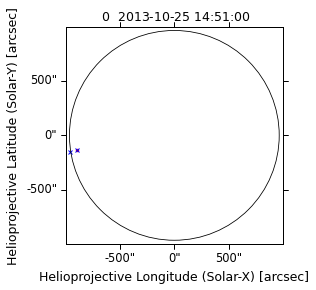

In [140]:
%matplotlib inline
my_map.plot(alpha=0)
my_map.draw_limb(color="k")
ax = plt.gca()
ax.plot_coord(coords_hpc[20], color="r", marker=".")
ax.plot_coord(coords_hc, color="b", marker="x")
ax.plot_coord(test2, color="b", marker="x")

In [156]:
coords_hc.cylindrical.phi.value + 270

98.28216038529331

In [155]:
360/2

180.0

In [157]:
180 - (-90)

270

In [158]:
coords_hpc[20]

<SkyCoord (Helioprojective: obstime=2013-10-25T14:51:00.000000000, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2013-10-25T14:51:00.000000000): (lon, lat, radius) in (deg, deg, AU)
    (0., 4.99336141, 0.99425378)>): (Tx, Ty, distance) in (arcsec, arcsec, km)
    (-897.20388297, -130.60217643, 1.48499002e+08)>

In [161]:
coords_hpc[20].transform_to(frames.Heliocentric).cylindrical

<CylindricalRepresentation (rho, phi, z) in (km, deg, km)
    (652741.56363256, -171.71783961, 240680.16350859)>

In [164]:
final_list_x.iloc[48]

index                                                          14900
time_start                                     2017-09-10 15:35:00.0
time_end                                       2017-09-10 16:31:00.0
time_peak                                      2017-09-10 16:06:00.0
xray_class                                                      X8.2
lat_hg                                                            -8
long_hg                                                           88
long_carr                                                     115.46
nar                                                          12673.0
ename                                              gev_20170910_1535
url_nar            http://www.solarmonitor.org/region.php?date=20...
url_flare          http://www.lmsal.com/solarsoft/latest_events_a...
goes_class_ind                                                     X
goes_class_val                                               0.00082
tstart_datetime                   

In [165]:
coords_hpc[48]

<SkyCoord (Helioprojective: obstime=2017-09-10T15:35:00.000000000, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2017-09-10T15:35:00.000000000): (lon, lat, radius) in (deg, deg, AU)
    (0., 7.2471978, 1.0068141)>): (Tx, Ty, distance) in (arcsec, arcsec, km)
    (942.95528619, -135.69862192, 1.50607215e+08)>